# Trabajo Práctico Final: Traxbot (Localización y Movimiento)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Parte 1. Localización

In [3]:
sys.path.append("part_1")
!tree part_1

part_1
├── matrix.py
├── parte_1.py
├── __pycache__
│   ├── __init__.cpython-37.pyc
│   ├── matrix.cpython-37.pyc
│   ├── matrix.cpython-38.pyc
│   ├── parte_1.cpython-37.pyc
│   ├── robot.cpython-37.pyc
│   └── robot.cpython-38.pyc
└── robot.py

1 directory, 9 files


In [4]:
# demo_grading() es la función de evaluación del resultado
# naive_next_pos() es la estrategia de localización
from parte_1 import demo_grading, naive_next_pos
from matrix import robot

In [5]:
help(robot.__init__)

Help on function __init__ in module matrix:

__init__(self, x=0.0, y=0.0, heading=0.0, turning=0.6283185307179586, distance=1.0)
    This function is called when you create a new robot. It sets some of
    the attributes of the robot, either to their default values or to the values
    specified when it is created.



In [6]:
help(robot.set_noise)

Help on function set_noise in module matrix:

set_noise(self, new_t_noise, new_d_noise, new_m_noise)
    This lets us change the noise parameters, which can be very
    helpful when using particle filters.



Función para realizar un caso de prueba con una función de estimación.

In [7]:
def testcase(x,y,heading,turning,distance,new_t_noise,new_d_noise,new_m_noise,estimator):
    test_target = robot(x, y, heading, turning, distance)
    test_target.set_noise(new_t_noise, new_d_noise, new_m_noise)
    localized, history = demo_grading(estimator, test_target)
    plot_history(history)

Parámetros del escenario a ensayar.

In [8]:
x = 2.1
y = 4.3
heading = 0.5
turning = 2.0*np.pi / 34.0
distance = 1.5

new_t_noise = 0.0
new_d_noise = 0.0
new_m_noise = 0.0

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_history(history,error_threeshold = 0.1):
    """ Muestra el histórico de posición. Cada entrada es una tupla (x_real,y_real,x_est,y_est,error)
    """
    fig,axes = plt.subplots(4,1,figsize=(22,20))
    
    x_real = history[:,0]
    y_real = history[:,1]
    x_pred = history[:,2]
    y_pred = history[:,3]

    # XY
    axes[0].scatter(history[:,0],history[:,1],color="b");
    axes[0].scatter(history[:,2],history[:,3],color="r");
    axes[0].grid(which="both")
    axes[0].axis('square')
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title("XY")
    axes[0].legend(["Posición real","Estimación"]);

    axes[1].plot(np.arange(0,len(history)),history[:,2],color="r")
    axes[1].scatter(np.arange(0,len(history)),history[:,0],color="b")
    axes[1].grid(which="both")
    axes[1].set_xlabel("tiempo")
    axes[1].set_ylabel("x")
    axes[1].set_title("x,$\hat{x}$")
    axes[1].legend(["Estimación","Posición real"]);

    axes[2].plot(np.arange(0,len(history)),history[:,3],color="r")
    axes[2].scatter(np.arange(0,len(history)),history[:,1],color="b")
    axes[2].grid(which="both")
    axes[2].set_xlabel("tiempo")
    axes[2].set_ylabel("y")
    axes[2].set_title("y,$\hat{y}$")
    axes[2].legend(["Estimación","Posición real"]);
        
    mse = np.sqrt((x_real-x_pred)**2 + (y_real-y_pred)**2)
    axes[3].plot(np.arange(0,len(history)),mse,color="b")
    axes[3].grid(which="both")
    axes[3].set_xlabel("tiempo")
    axes[3].set_ylabel("MSE")
    axes[3].set_title("MSE")    
    axes[3].axhline(error_threeshold)
    axes[3].legend(["MSE","Umbral de error"])
    
    fig.tight_layout()

### Estrategia de localización "boba"

Sorry, it took you too many steps to localize the target.


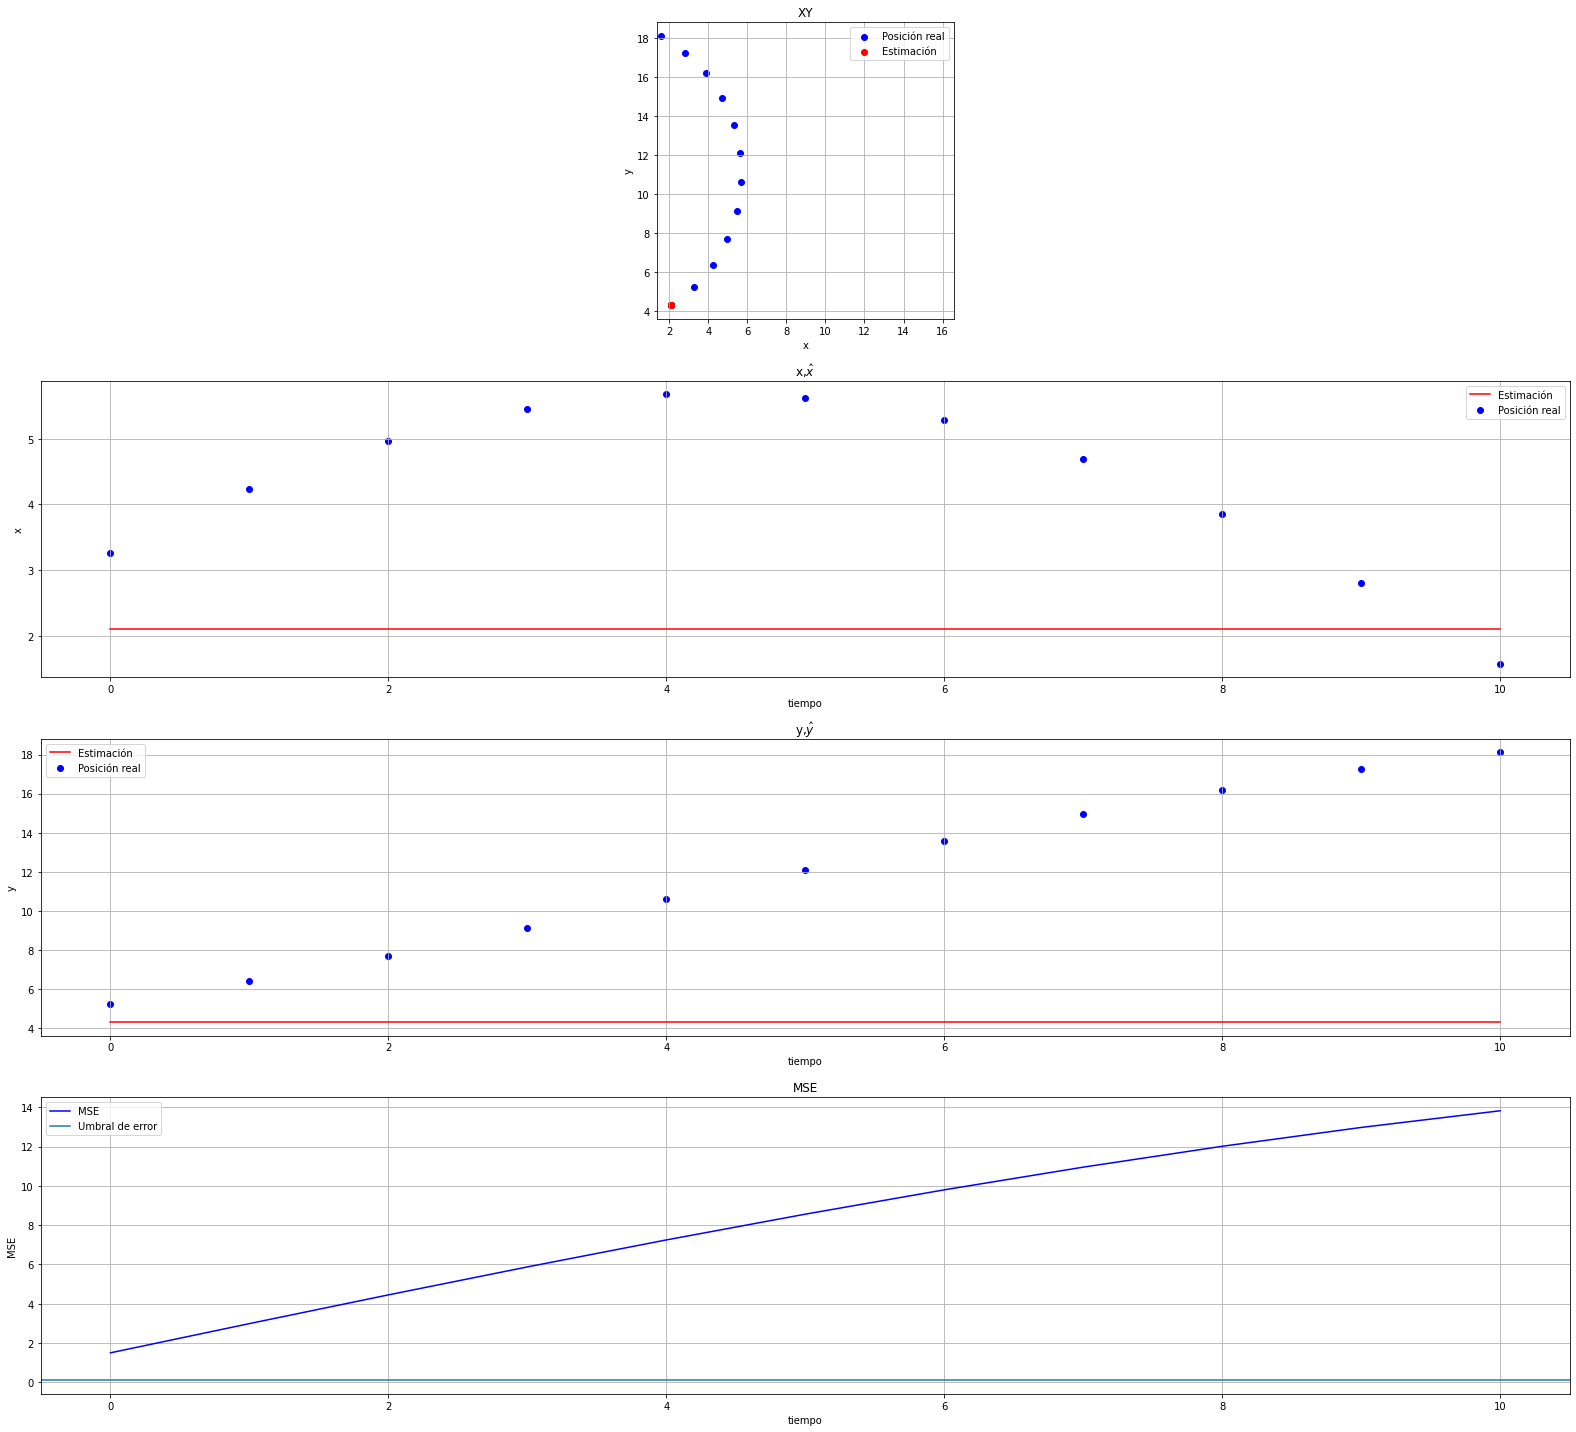

In [10]:
estimator = naive_next_pos
testcase(x,y,heading,turning,distance,new_t_noise,new_d_noise,new_m_noise,estimator)

## Estrategia de localización con estimación

Como se ve en el diagrama, el robot traza una trayectoria circular y cada un determinado tiempo transmite su posición exacta $X_t$.

<center><img src="./assets/diagram_parte1.png"/></center>

Como la medición no tiene error y el intervalo de tiempo entre mediciones es constante, puede estimarse $x_{t+1}$ por trigonometría. 

Siendo:

- $x,y$: la posición actual.
- $dist$: la distancia recorrida entre cada medición (velocidad).
- $\theta$: la orientación.
- $\Delta\theta$: la velocidad de giro.

Pueden calcularse $\hat{x}_{t+1}$ e $\hat{y}_{t+1}$:

$$
dx = x_{t}-x_{t-1} \\
dy = y_{t}-y_{t-1} \\
dist = \sqrt{dx^2+dy^2} \\
\theta_t = tan^{-1}(\frac{dy}{dx}) \\
\Delta\theta = \theta_t - \theta_{t-1} \\
\hat{x}_{t+1} = x_t + dist \cdot cos(\theta+ \Delta\theta) \\
\hat{y}_{t+1} = y_t + dist \cdot sin(\theta+ \Delta\theta) \\
$$

In [11]:
class BasicEstimator:
        """ Estimador de posición básico usando trigonometría.
        """
    
        def __init__(self):
            self.x = 0
            self.y = 0
            self.distance = 1
            self.heading = np.pi/2
            self.turning = np.pi/8
            self.history = []
        
        # This is the function you have to write. The argument 'measurement' is a
        # single (x, y) point. This function will have to be called multiple
        # times before you have enough information to accurately predict the
        # next position. The OTHER variable that your function returns will be
        # passed back to your function the next time it is called. You can use
        # this to keep track of important information over time.
        def estimate_next_pos(self,measurement, OTHER = None):
            self.x = measurement[0]
            self.y = measurement[1]
            
            if len(self.history) > 0:
                dx = self.x - self.history[-1][0]
                dy = self.y - self.history[-1][1]
                self.heading = np.arctan2(dy,dx)
                self.distance = np.sqrt(dx**2 + dy**2)
                self.turning = self.heading-self.history[-1][3]
            
            self.history.append((self.x,self.y,self.distance,self.heading,self.turning))
            
            x_hat = self.x + self.distance*np.cos(self.heading + self.turning)
            y_hat = self.y + self.distance*np.sin(self.heading + self.turning)            
                       
            # You must return xy_estimate (x, y), and OTHER (even if it is None)
            # in this order for grading purposes.            
            xy_estimate = [x_hat,y_hat]
            return xy_estimate, OTHER                        

You got it right! It took you  3  steps to localize.


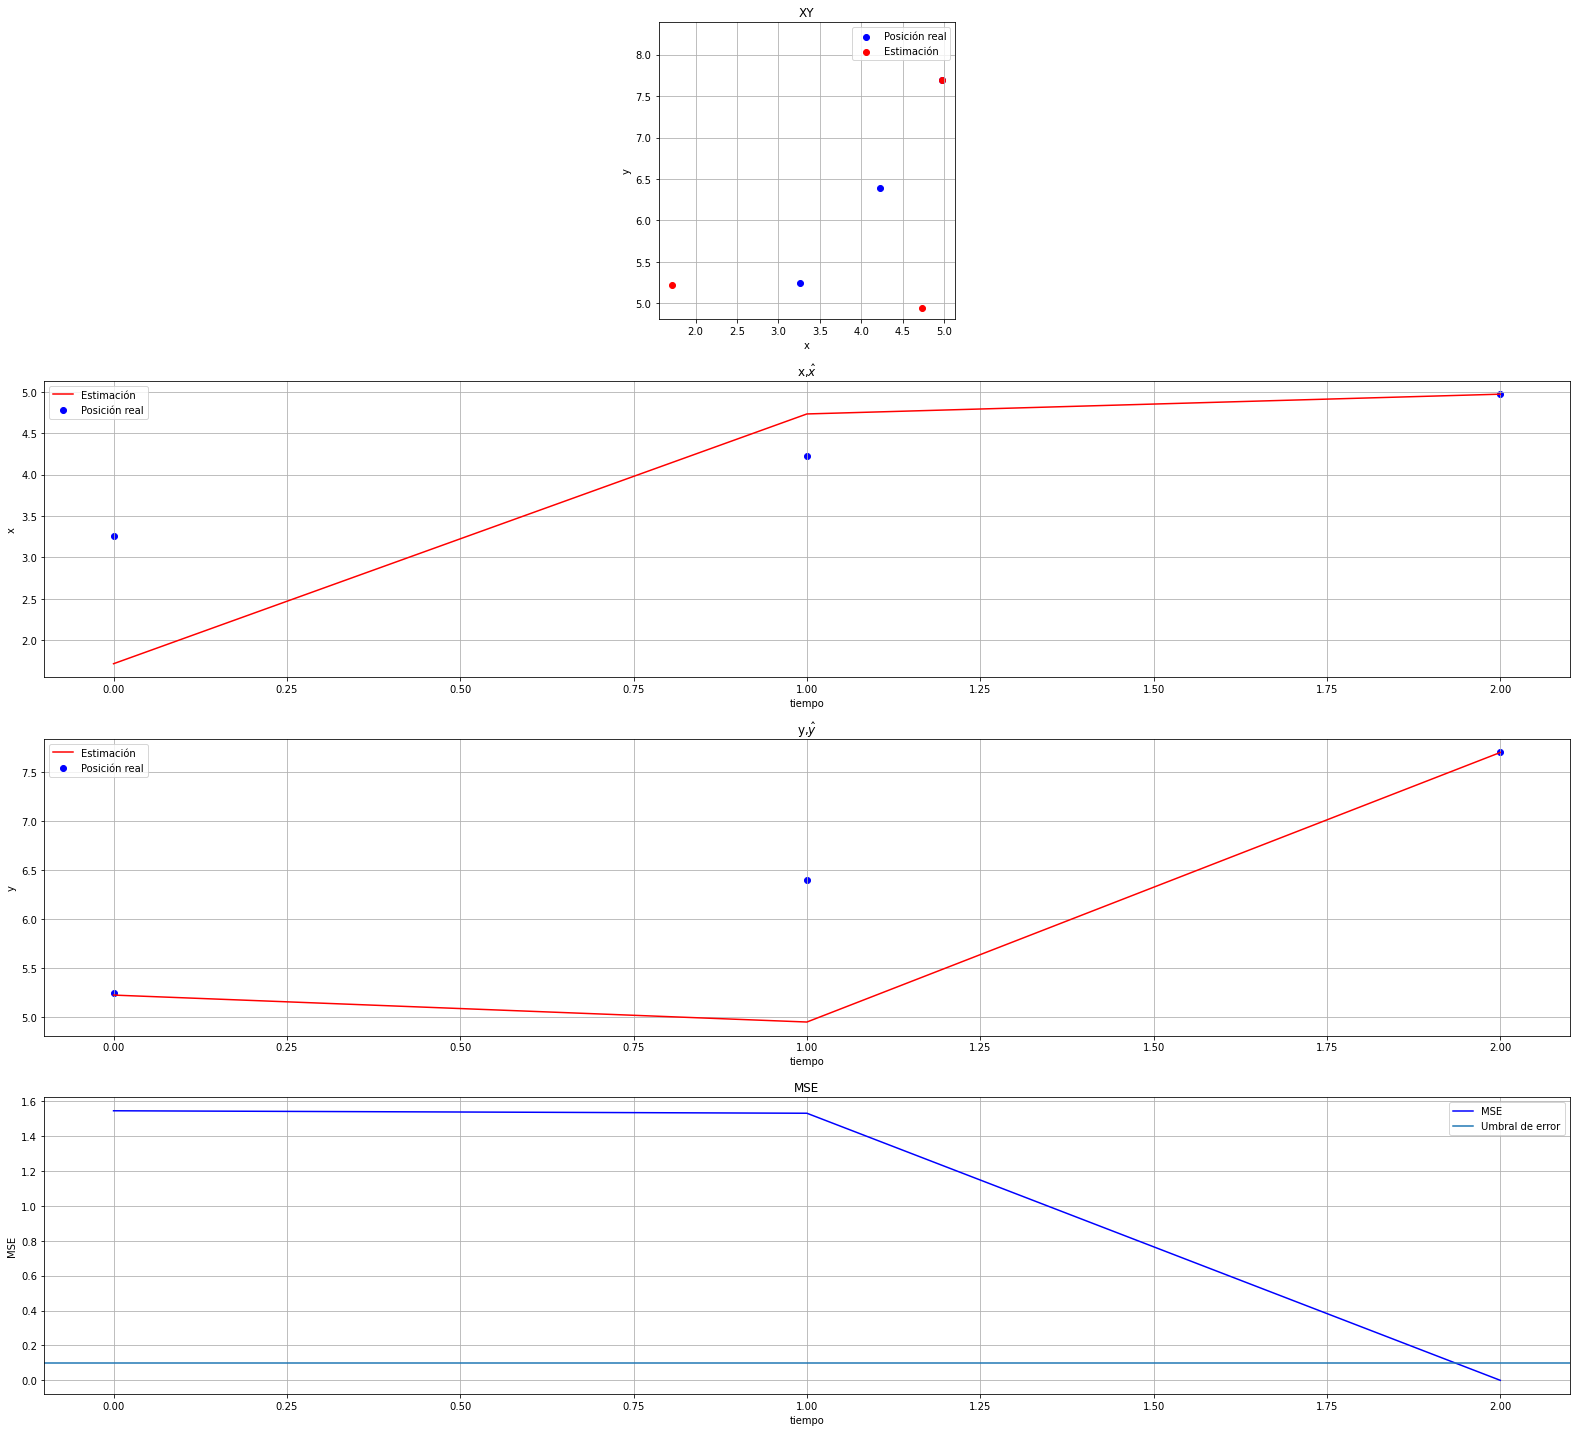

In [12]:
estimator = BasicEstimator()
testcase(x,y,heading,turning,distance,new_t_noise,new_d_noise,new_m_noise,lambda z,other: estimator.estimate_next_pos(z,other))

Conclusiones:
- Asumiendo que la velocidad de giro y de avance son constantes y que las mediciones no tienen error, es suficiente esta aproximación para estimar la posición siguiente.